In [1]:
!pip install gymnasium

In [2]:
from matplotlib import matplotlib_fname
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make("FrozenLake-v1", desc=None, map_name = "4x4")
num_states = env.observation_space.n
num_actions = env.action_space.n
epsilon = 0.1
num_runs = 10
num_segments = 500
num_episodes = 10

Selecting an action for exploration

In [3]:
def convert_reset_variables(scene):
    observation, information = scene
    return observation
def convert_step_variables(current_scene):
    state, reward, done, _, info = current_scene
    return state, reward, done
def softmax(x, temperature):
    e = (x/temperature)
    exp_values = np.exp(e)
    probs = exp_values / np.sum(exp_values)
    return probs
def select_action(state, q_table, temperature, reward):
    action_probs = softmax(q_table[state,:], temperature)
    action = np.random.choice([0,1,2,3], p=action_probs)
    return action

Update for SARSA and Expected SARSA

In [4]:
def update_sarsa(q_table, state, action, reward, next_state, next_action, alpha, gamma):
    if next_action is None:
        return q_table
    else:
        q_predict = q_table[state, action]
        q_target = reward + gamma * q_table[next_state, next_action]
        q_table[state, action] = q_table[state, action] + alpha * (q_target - q_predict)
        # if reward:
        #     print(f"After getting reward 1 updated Q-table is {q_table}")
    return q_table
def update_expected_sarsa(q_table, state, action, reward, next_state, alpha, gamma, temperature):
    next_action_probs = softmax(q_table[next_state, :], temperature)
    expected_q_next = np.sum(next_action_probs * q_table[next_state, :])
    q_predict = q_table[state, action]
    q_target = reward + gamma * expected_q_next
    q_table[state, action] += alpha * (q_target - q_predict)
    return q_table

To run a single episode until agent reached a goal state or dies

In [5]:
def run_episode(env, q_table, alpha, gamma, temperature, algorithm):
    current_scene = env.reset()
    r = 0
    state = convert_reset_variables(current_scene)
    action = select_action(state, q_table, temperature, r)
    done = False
    while not done:
        current_scene = env.step(action)
        next_state, reward, done = convert_step_variables(current_scene)
        if algorithm == "SARSA":
            next_action = select_action(next_state, q_table, temperature, reward)
            q_table = update_sarsa(q_table, state, action, reward, next_state, next_action, alpha, gamma)
        elif algorithm == "Expected SARSA":
            next_action = select_action(next_state, q_table, temperature, reward)
            q_table = update_expected_sarsa(q_table, state, action, reward, next_state, alpha, gamma, temperature)
        state = next_state
        action = next_action
        r += reward
    return r, q_table

Run optimal policy after learning the Q-table

In [6]:
def optimal_policy(env, segment, q_table):
    current_scene = env.reset()
    r = 0
    state = convert_reset_variables(current_scene)
    action_values = q_table[state, :]
    
    if any(action_values > np.max(action_values) - 1e-6):
        
        action = np.argmax(action_values)
    
    elif any(action_values[:-1] == action_values[1:]) and \
         any(action_values[:-2] == action_values[1:-1]) and \
         any(action_values[:-3] == action_values[1:-2]):
        max_action_indices = np.where(action_values == np.max(action_values))[0]
        action = np.random.choice(max_action_indices)
    
    elif any(action_values[:-1] == action_values[1:]) and \
         any(action_values[:-2] == action_values[1:-1]):
        max_action_indices = np.where(action_values == np.max(action_values))[0]
        action = np.random.choice(max_action_indices)
    
    elif all(action_values[:-1] == action_values[1:]):
        action = np.random.randint(0, len(action_values))
    
    else:
        action = np.argmax(action_values)
    
    done = False
    while not done:
        current_scene = env.step(action)
        next_state, reward, done = convert_step_variables(current_scene)
        action_values = q_table[next_state, :]
        if any(action_values > np.max(action_values) - 1e-6):
            next_action = np.argmax(action_values)
    
        elif any(action_values[:-1] == action_values[1:]) and \
             any(action_values[:-2] == action_values[1:-1]) and \
             any(action_values[:-3] == action_values[1:-2]):
            max_action_indices = np.where(action_values == np.max(action_values))[0]
            next_action = np.random.choice(max_action_indices)
        elif any(action_values[:-1] == action_values[1:]) and \
             any(action_values[:-2] == action_values[1:-1]):
            max_action_indices = np.where(action_values == np.max(action_values))[0]
            next_action = np.random.choice(max_action_indices)
        elif all(action_values[:-1] == action_values[1:]):
            next_action = np.random.randint(0, len(action_values))
        else:
            next_action = np.argmax(action_values)
    
        state = next_state
        action = next_action
        r += reward
    return r

Training for different segments and returning the values.

In [7]:
from pyparsing import actions
def train(env,num_segments, num_episodes, algorithm, alpha, gamma, temperature):
    q_table = np.zeros((num_states, num_actions))
    q_table[num_states-1, :] = 0
    train_return = np.zeros((num_segments, num_episodes))
    test_return = np.zeros((num_segments, 1))
    train_segment = np.zeros((num_segments,1))
    test_segment = np.zeros((num_segments,1))
    for segment in range(num_segments):
        reward = 0
        for episode in range(num_episodes):
            r, q_table = run_episode(env, q_table, alpha, gamma, temperature, algorithm=algorithm)         
            train_return[segment, episode] = r
            reward += r
        train_segment[segment,0] = reward
        optimal = optimal_policy(env, segment, q_table)
        test_return[segment,0] = optimal
    avg_train = np.average(train_segment, axis=1)
    avg_test = test_return[num_segments-1]
    return train_return, test_return, avg_train, avg_test

Run for different values of temperatures and alphas to check for the best hyper parameters

In [12]:
def run(env, num_runs, num_segments, num_episodes, alphas, temps,gamma):
    sarsa_train = np.zeros((num_runs, 1))
    exp_train = np.zeros((num_runs, 1))
    sarsa_test = np.zeros((num_runs,1))
    exp_test = np.zeros((num_runs,1))
    avg_train_returns_SARSA = np.zeros((len(temps),len(alphas)))
    avg_train_returns_exp = np.zeros((len(temps),len(alphas)))
    avg_test_returns_SARSA = np.zeros((len(temps),len(alphas)))
    avg_test_returns_exp = np.zeros((len(temps),len(alphas)))
    for tx,t in enumerate(temps):
        for ax,a in enumerate(alphas):
            for run in range(num_runs):
                train_returns_SARSA, test_returns_SARSA, train_segment_SARSA, test_segment_SARSA = train(env, num_segments, num_episodes, algorithm="SARSA", alpha = a, gamma=gamma, temperature=t)
                train_returns_exp, test_returns_exp, train_segment_exp, test_segment_exp = train(env, num_segments, num_episodes, algorithm="Expected SARSA", alpha = a, gamma=gamma, temperature=t)
                sarsa_train[run, 0] = train_segment_SARSA[num_segments-1]
                exp_train[run,0] = train_segment_exp[num_segments-1]
                sarsa_test[run,0] = test_segment_SARSA
                exp_test[run,0] = test_segment_exp
                print(f"Run {run}, alpha {a}, temp {t}, Average Return for training of SARSA: {train_segment_SARSA[num_segments-1]}")
                print(f"Run {run}, alpha {a}, temp {t}, Average Return for training of Expected SARSA: {train_segment_exp[num_segments-1]}")
            avg_train_returns_SARSA[tx,ax] = np.average(sarsa_train)
            avg_test_returns_SARSA[tx,ax] = np.average(sarsa_test)   
            avg_train_returns_exp[tx,ax] = np.average(exp_train)
            avg_test_returns_exp[tx,ax] = np.average(exp_test)
          #print(np.shape(train_returns_SARSA))           
    #print(avg_train)
    return avg_train_returns_SARSA, avg_train_returns_exp,avg_test_returns_SARSA, avg_test_returns_exp
    

Leaning rates = [0.1, 0.25, 0.5]
Temperature values = [0.1, 1, 10]

In [13]:
alphas = [0.03, 0.05, 0.08]
temps = [0.01, 0.02, 0.03]
gamma = 0.95

In [16]:
alphas = [0.03, 0.05, 0.08]
temps = [0.005, 0.007, 0.009]
gamma = 0.95

In [17]:
sarsa_train, expected_train, sarsa_test, expected_test= run(env, num_runs, num_segments, num_episodes, alphas, temps,gamma)

Run 0, alpha 0.03, temp 0.005, Average Return for training of SARSA: 4.0
Run 0, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 6.0
Run 1, alpha 0.03, temp 0.005, Average Return for training of SARSA: 7.0
Run 1, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 3.0
Run 2, alpha 0.03, temp 0.005, Average Return for training of SARSA: 1.0
Run 2, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 0.0
Run 3, alpha 0.03, temp 0.005, Average Return for training of SARSA: 1.0
Run 3, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 1.0
Run 4, alpha 0.03, temp 0.005, Average Return for training of SARSA: 1.0
Run 4, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 1.0
Run 5, alpha 0.03, temp 0.005, Average Return for training of SARSA: 1.0
Run 5, alpha 0.03, temp 0.005, Average Return for training of Expected SARSA: 4.0
Run 6, alpha 0.03, temp 0.005, Average Return for training of SARSA: 2

Run 3, alpha 0.08, temp 0.007, Average Return for training of SARSA: 4.0
Run 3, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 0.0
Run 4, alpha 0.08, temp 0.007, Average Return for training of SARSA: 3.0
Run 4, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 0.0
Run 5, alpha 0.08, temp 0.007, Average Return for training of SARSA: 0.0
Run 5, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 4.0
Run 6, alpha 0.08, temp 0.007, Average Return for training of SARSA: 1.0
Run 6, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 1.0
Run 7, alpha 0.08, temp 0.007, Average Return for training of SARSA: 2.0
Run 7, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 1.0
Run 8, alpha 0.08, temp 0.007, Average Return for training of SARSA: 1.0
Run 8, alpha 0.08, temp 0.007, Average Return for training of Expected SARSA: 9.0
Run 9, alpha 0.08, temp 0.007, Average Return for training of SARSA: 4

In [18]:
print(f"training results of SARSA: {sarsa_train}")
print(f"test results of SARSA: {sarsa_test}")
print(f"training results of Expected-SARSA: {expected_train}")
print(f"test results of Expected-SARSA: {expected_test}")

training results of SARSA: [[2.4 1.4 1.8]
 [1.5 2.3 1.8]
 [1.7 1.2 1.4]]
test results of SARSA: [[0.2 0.2 0.3]
 [0.2 0.2 0.3]
 [0.2 0.3 0.2]]
training results of Expected-SARSA: [[2.6 1.3 2.2]
 [1.  2.2 2.7]
 [1.6 1.8 2.8]]
test results of Expected-SARSA: [[0.2 0.2 0.3]
 [0.3 0.4 0.3]
 [0.4 0.4 0.1]]


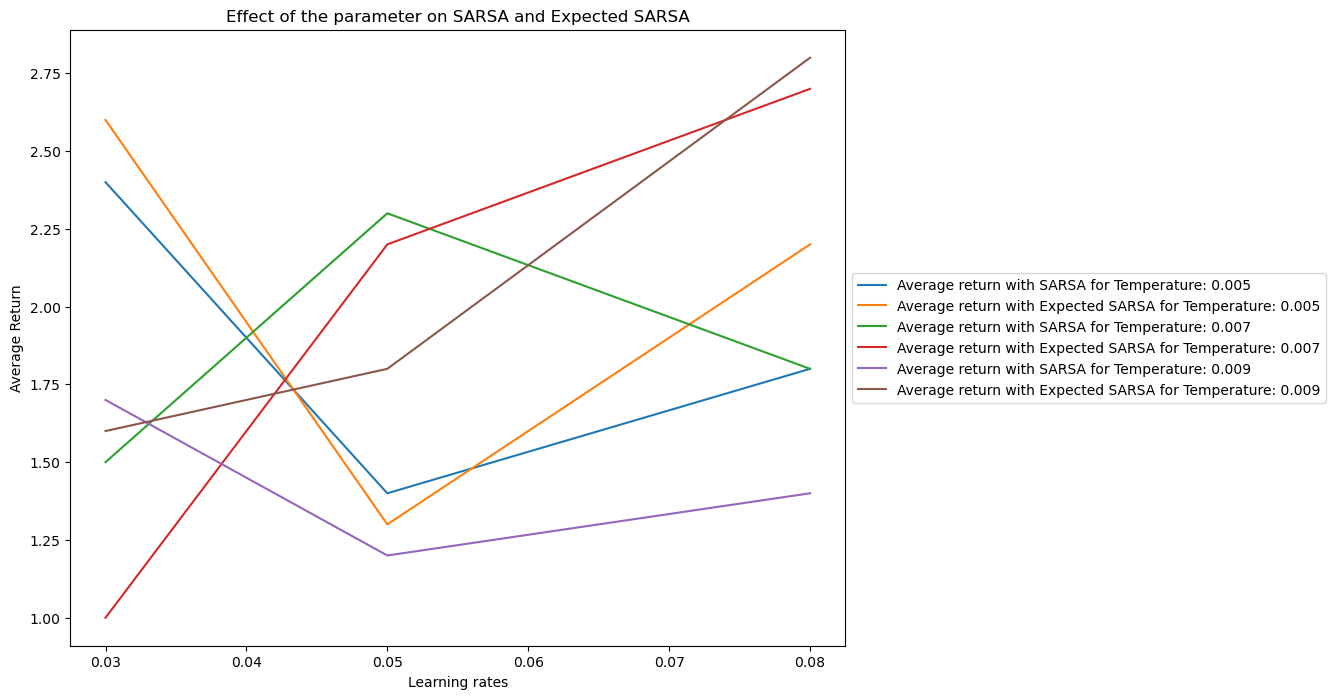

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
for tx, t  in enumerate(temps):
    ax.plot(alphas, sarsa_train[tx, :], label=f"Average return with SARSA for Temperature: {t}")
    ax.plot(alphas, expected_train[tx, :], label = f"Average return with Expected SARSA for Temperature: {t}")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Learning rates")
ax.set_ylabel("Average Return")
ax.set_title(f"Effect of the parameter on SARSA and Expected SARSA")
plt.show()

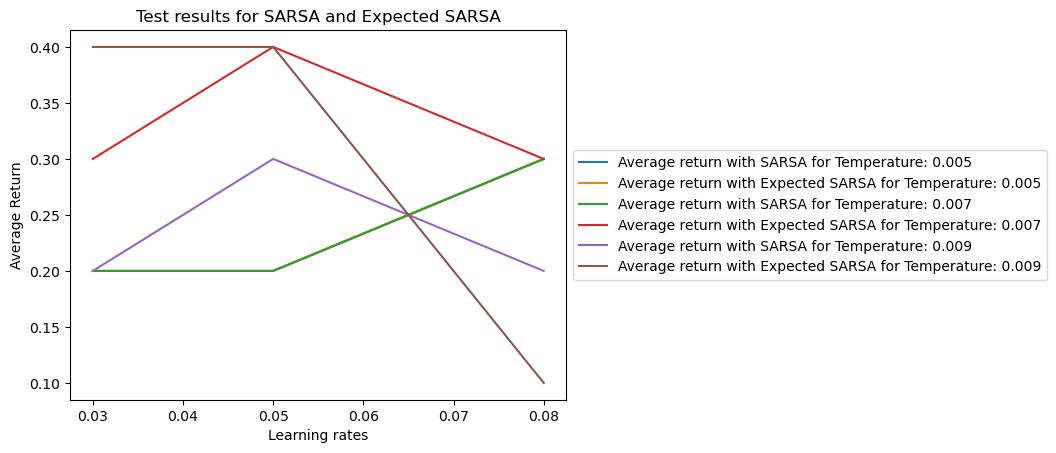

In [20]:
fig, ax = plt.subplots()
for tx, t  in enumerate(temps):
    ax.plot(alphas, sarsa_test[tx, :], label=f"Average return with SARSA for Temperature: {t}")
    ax.plot(alphas, expected_test[tx, :], label = f"Average return with Expected SARSA for Temperature: {t}")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Learning rates")
ax.set_ylabel("Average Return")
ax.set_title(f"Test results for SARSA and Expected SARSA")
plt.show()

Leaning rates = [0.2, 0.4, 0.6] Temperature values = [0.1, 0.5, 1]

In [21]:
sarsa_train = []
sarsa_test = []
exp_train = []
exp_test = []

In [23]:
for run in range(num_runs):
    train_sarsa, test_sarsa, segment_sarsa_train, segment_sarsa_test = train(env,num_segments, num_episodes, algorithm="SARSA", alpha=0.03, gamma=0.95, temperature=0.005)
    train_exp, test_exp,segment_exp_train, segment_exp_test = train(env,num_segments, num_episodes, algorithm="Expected SARSA", alpha=0.08, gamma=0.95, temperature=0.009)
    sarsa_train.append(segment_sarsa_train)
    sarsa_test.append(test_sarsa)
    exp_train.append(segment_exp_train)
    exp_test.append(test_exp)
    

In [24]:
mean_sarsa_train = np.average(sarsa_train, axis=0)
mean_sarsa_test = np.average(sarsa_test, axis=0)
mean_exp_train = np.average(exp_train, axis=0)
mean_exp_test = np.average(exp_test, axis=0)
std_sarsa_train = np.std(sarsa_train, axis=0)
std_sarsa_test = np.std(sarsa_test, axis=0)
std_exp_train = np.std(exp_test, axis=0)
std_exp_test = np.std(exp_test, axis=0)

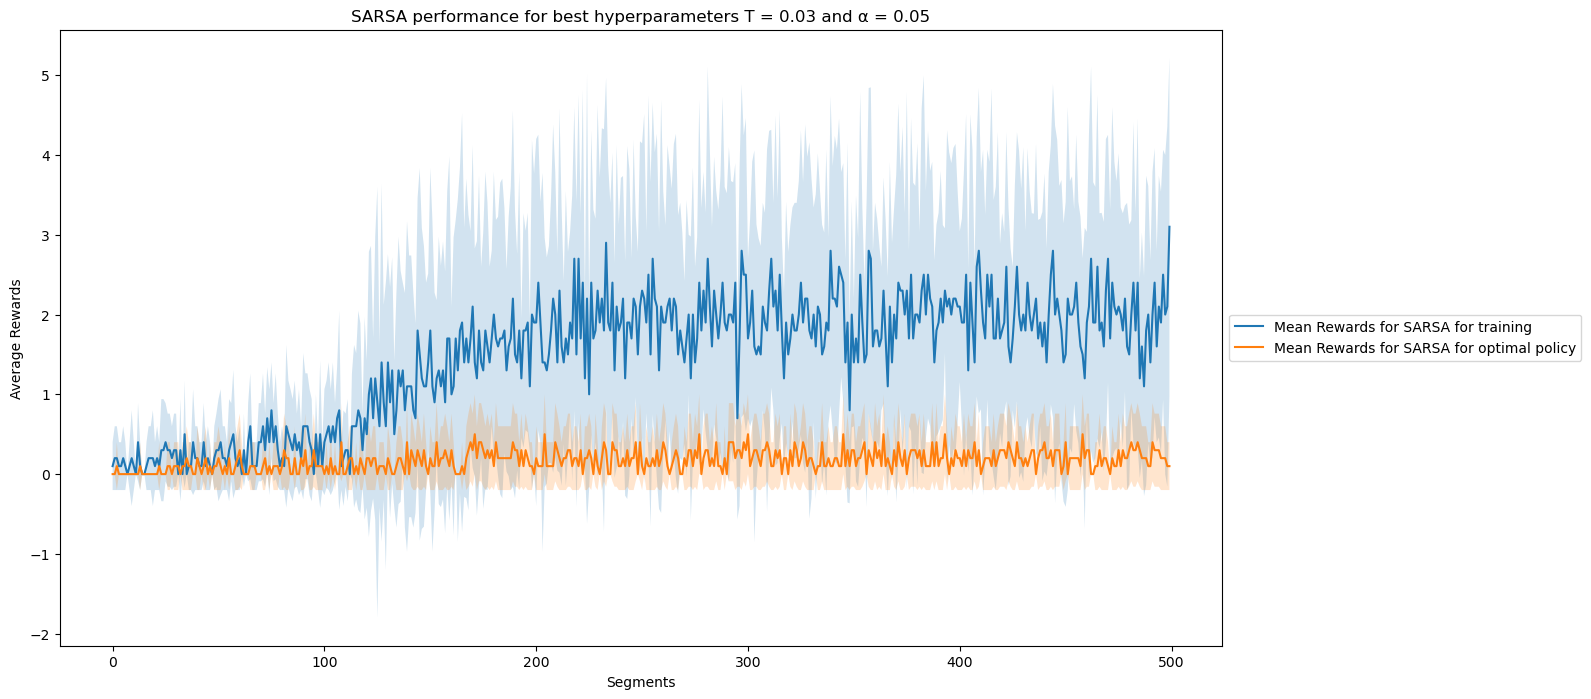

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(num_segments), mean_sarsa_train, label=f"Mean Rewards for SARSA for training")
# ax.plot(range(num_segments), std_sarsa_train, label=f"Standard deviation for SARSA for training")
ax.fill_between(range(num_segments), mean_sarsa_train - std_sarsa_train, mean_sarsa_train + std_sarsa_train, alpha=0.2)
ax.plot(range(num_segments), mean_sarsa_test, label=f"Mean Rewards for SARSA for optimal policy")
ax.fill_between(range(num_segments), np.ravel(mean_sarsa_test - std_sarsa_test),np.ravel(mean_sarsa_test + std_sarsa_test) , alpha=0.2)
# ax.plot(range(num_segments), mean_exp_train, label=f"Mean Rewards for Expected SARSA for training")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Segments")
ax.set_ylabel("Average Rewards")
ax.set_title(f"SARSA performance for best hyperparameters T = 0.03 and \u03B1 = 0.05")
plt.show()

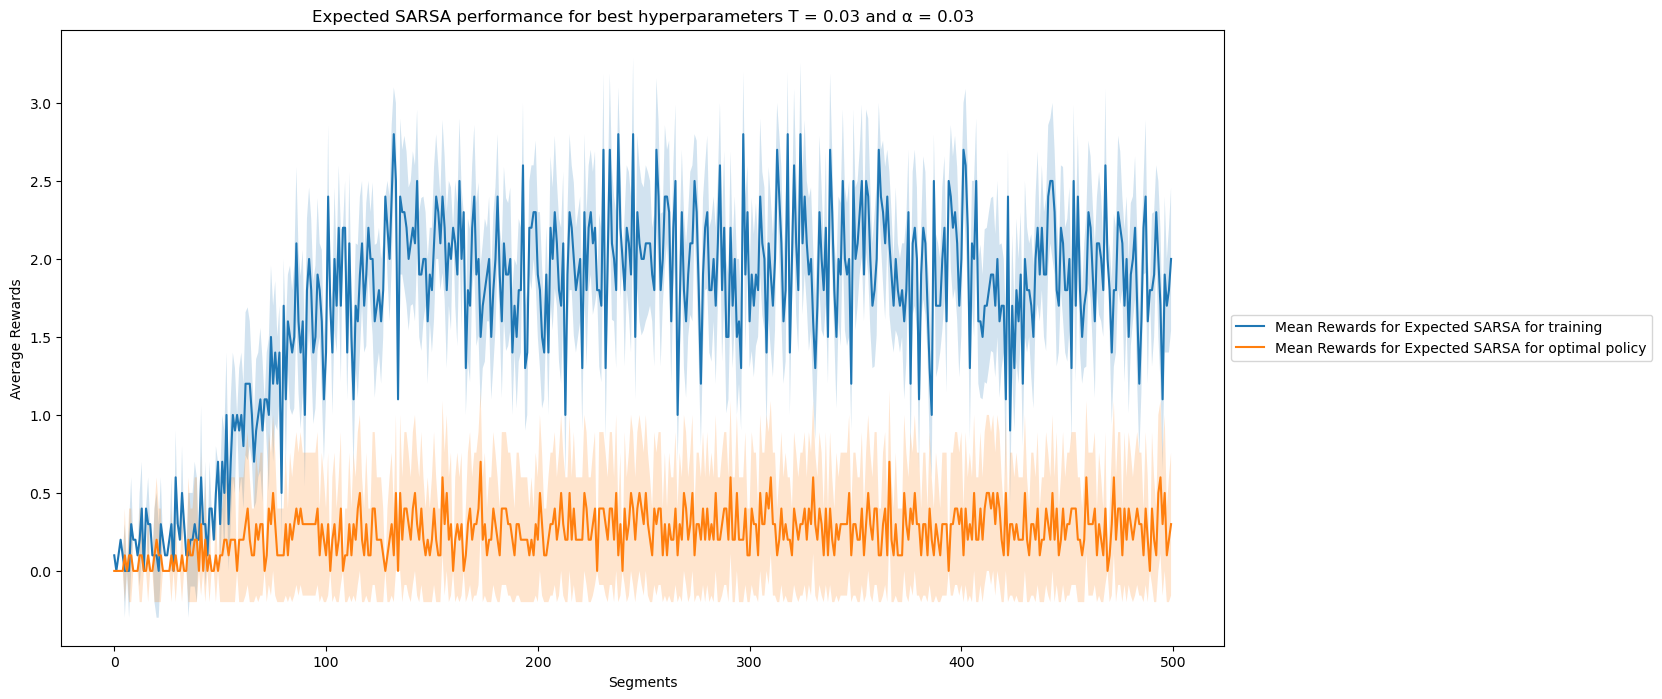

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(num_segments), mean_exp_train, label=f"Mean Rewards for Expected SARSA for training")
ax.fill_between(range(num_segments), mean_exp_train - np.ravel(std_exp_train), mean_exp_train + np.ravel(std_exp_train), alpha=0.2)
ax.plot(range(num_segments), mean_exp_test, label=f"Mean Rewards for Expected SARSA for optimal policy")
ax.fill_between(range(num_segments), np.ravel(mean_exp_test - std_exp_test),np.ravel(mean_exp_test + std_exp_test) , alpha=0.2)
# ax.plot(range(num_segments), mean_exp_train, label=f"Mean Rewards for Expected SARSA for training")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Segments")
ax.set_ylabel("Average Rewards")
ax.set_title(f"Expected SARSA performance for best hyperparameters T = 0.03 and \u03B1 = 0.03")
plt.show()

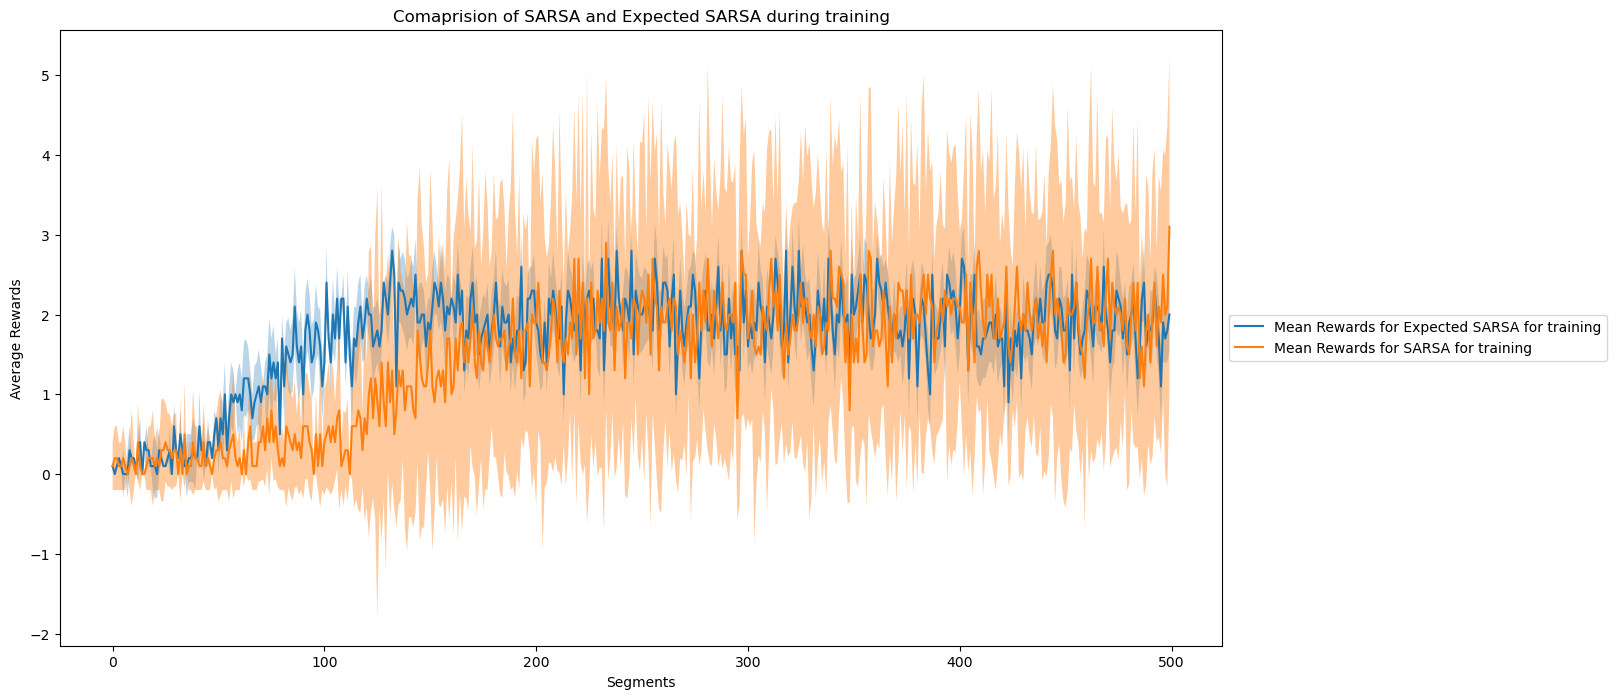

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(range(num_segments), mean_exp_train, label=f"Mean Rewards for Expected SARSA for training")
ax.fill_between(range(num_segments), mean_exp_train - np.ravel(std_exp_train), mean_exp_train + np.ravel(std_exp_train), alpha=0.3)
ax.plot(range(num_segments), mean_sarsa_train, label=f"Mean Rewards for SARSA for training")
ax.fill_between(range(num_segments), np.ravel(mean_sarsa_train - std_sarsa_train),np.ravel(mean_sarsa_train + std_sarsa_train) , alpha=0.4)
# ax.plot(range(num_segments), mean_exp_train, label=f"Mean Rewards for Expected SARSA for training")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Segments")
ax.set_ylabel("Average Rewards")
ax.set_title(f"Comaprision of SARSA and Expected SARSA during training")
plt.show()